In [1]:
%reload_ext autoreload
%autoreload 2

In [0]:
#from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import math
import sys
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from pathlib import Path
#import cv2
from fastai.vision import *
from fastai.metrics import error_rate

#from utils.trainer_functions import *

In [4]:
img1 = open_image(r"C:\Users\payman\Documents\Insight_Project\scrapworks\Test_Models\Model1\Data/trainX_pngs/pdf_input_000_1-000001.png")

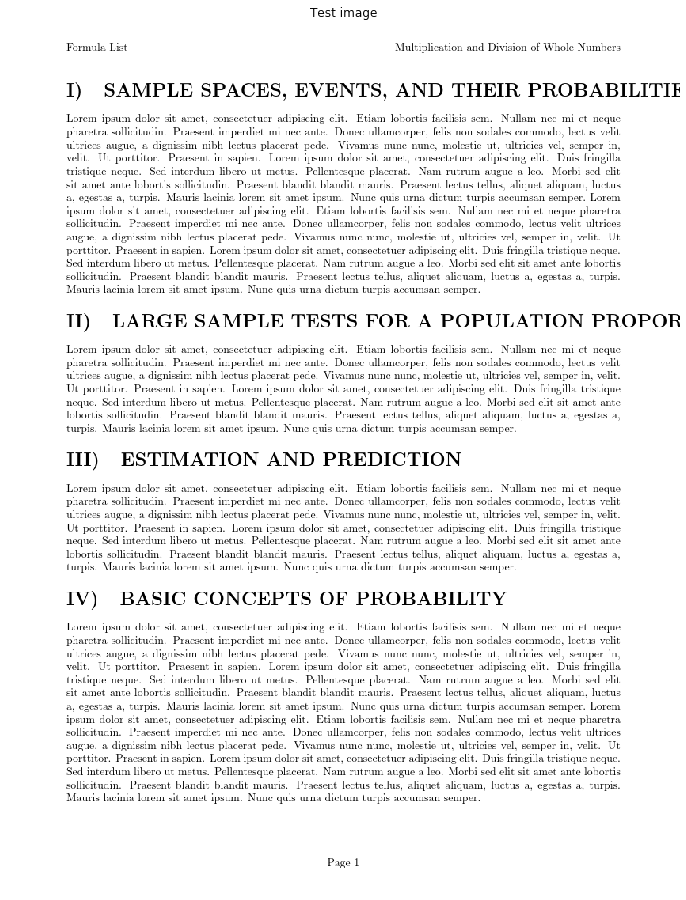

In [5]:
img1.show(figsize=(28, 16), title='Sample Train image')

# Normalize the masks...
def normalize_images(root_path, mask_folder, save_folder):
    
    root_path = Path(r"C:\Users\payman\Documents\Insight_Project\scrapworks\Test_Models\Model1\Data")
    mask_path = root_path/'trainY_pngs'
    save_path = root_path/'trainY_pngs_norm_run1'

    save_path.mkdir(parents = True ,exist_ok = True)
    
    colours = [([255,255,255], 0),
               ([255,0,0], 1),
               ([0,0,255], 2),
               ([255,242,0], 3),
               ([0,255,0],4),
          ]
    for files in mask_path.iterdir():
        reader = imageio.get_reader(str(files))
        img = reader.get_data(0)
        norm_img = np.zeros(img.shape[:2], dtype = np.uint8)
        print(norm_img.shape)
                
        for (colour, value) in colours:
            r,g,b = colour
            colours_match = np.all([img[:,:,0] == r, img[:,:,1] == g, img[:,:,2] == b], axis=0)
            norm_img[colours_match] = value
        imageio.imwrite(str(save_path/files.name), norm_img)
        #print(np.amax(img))

"""Only run the below code if you need to normalize your masks"""
normalize_images(root_path = r"C:\Users\payman\Documents\Insight_Project\scrapworks\Test_Models\Model1\Data", 
                 mask_folder = 'trainY_pngs', 
                 save_folder = 'trainY_pngs_norm_run1')

In [6]:
"""Step 1: Determine where the training images are stored
changing the resize_method in the data = block will change how the images are resized.  
Your options are ResizeMethod.SQUISH and ResizeMethod.PAD"""

root_path = Path(r"C:\Users\payman\Documents\Insight_Project\scrapworks\Test_Models\Model1\Data")
seg_path = root_path/"trainX_pngs"
codes_path = root_path/"codes_run1.txt"

In [7]:
"""Step 2: Determine how to get the mask name from the image name"""
def get_y_lambda_function(root_path, mask_folder = 'trainY_pngs_norm_run1', image_folder = 'trainX_pngs'):
    return lambda filename: root_path/mask_folder/filename.relative_to(root_path/image_folder).parent/(filename.name.replace('input', 'target'))

get_mask_func = get_y_lambda_function(root_path)

In [8]:
"""Step 3: Change any of the default parameters:"""
lr = 2e-4                   #Learning Rate
bs = 4                      #Batch Size
size = 350 # 400                  #Size of the network (images reshaped to (sz, sz))
model = models.resnet34     #Model 
export_name = 'RandABHome.pkl'  #Export Name
wd = 1e-3
penalty = 1
tfms = get_transforms()
tfms = [[],[]]

In [9]:
"""Step 4: Detemine how you want you accuracy to be determined"""
def acc_segmentation(input_image, target):
    target = target.squeeze(1)
    return (input_image.argmax(dim=1)==target).float().mean()

In [10]:
"""Step 5: Load the pixel value to feature codes"""

codes = np.loadtxt(codes_path, dtype = 'str')
name2id = {code:number for number,code in enumerate(codes)}

In [11]:
"""Step 6: Create your dataset"""
#Note: Use ResizeMethod.PAD to pad to a square and SQUISH to squish the larger axis
data = (SegmentationItemList
         .from_folder(seg_path, recurse = True)
         .split_by_rand_pct()
         .label_from_func (get_mask_func, classes = codes)
         .transform(tfms = tfms, size = size, tfm_y = True, padding_mode = 'border', resize_method = ResizeMethod.SQUISH)
         .databunch(bs = bs, num_workers = 0))

In [0]:
"""Step 7: Train your learner """

learn = unet_learner(data, model, wd = wd, metrics = [acc_segmentation])
                 #loss_func = CrossEntropyFlat(axis=1, weight = torch.FloatTensor([1,penalty]).cuda())
                  #  )

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 23.4MB/s]


# Train the model with most of the layers frozen

epoch,train_loss,valid_loss,acc_segmentation,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


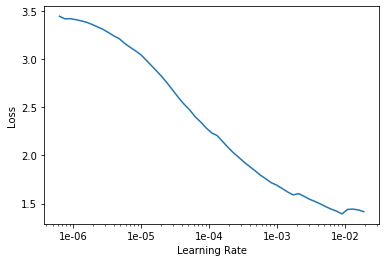

In [0]:
"""Find the appropriate learning rate by choosing an area of continuous descent"""

learn.lr_find()
learn.recorder.plot()
#The results indicate that 


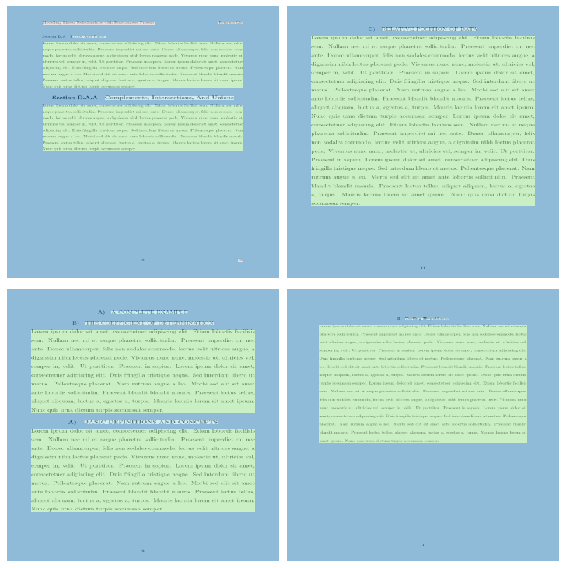

In [0]:
data.show_batch()

In [0]:
learn.fit_one_cycle(10, max_lr = lr)

epoch,train_loss,valid_loss,acc_segmentation,time
0,0.365094,0.257996,0.923480,04:46
1,0.240578,0.202022,0.936600,01:57
2,0.168726,0.143821,0.956264,01:57
3,0.138112,0.145979,0.961670,01:54
4,0.131402,0.139764,0.962348,01:52
5,0.106680,0.123730,0.961016,01:55
6,0.094265,0.103200,0.969028,01:54
7,0.072842,0.104099,0.968287,01:56
8,0.053907,0.136623,0.968048,01:56
9,0.055440,0.134623,0.967868,01:55


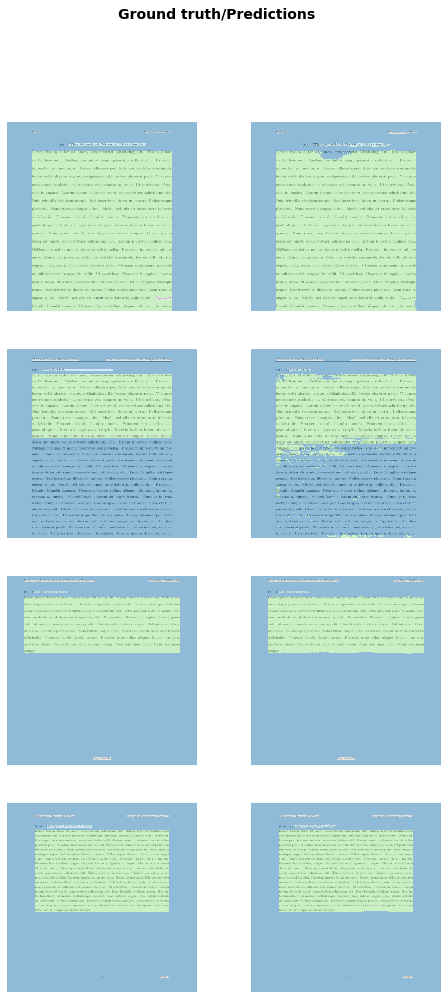

In [0]:
learn.show_results()

# Next we unfreeze the rest of the layers and retrain using a new learning rate

In [0]:
"""When we unfreeze the layers, they can all be trained"""
learn.unfreeze()

epoch,train_loss,valid_loss,acc_segmentation,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


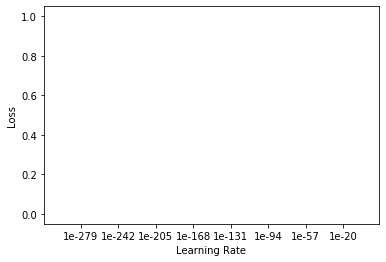

In [0]:
"""We must choose a new learning rate to optimize training"""

learn.lr_find(start_lr = 1e-4)
learn.recorder.plot()
#results suggest 

In [0]:
learn.fit_one_cycle(50, max_lr = lr/10)

epoch,train_loss,valid_loss,acc_segmentation,time
0,0.049576,0.131165,0.968028,01:59
1,0.050517,0.131828,0.968015,01:59
2,0.045911,0.133577,0.967442,02:00
3,0.049686,0.140474,0.967847,01:59
4,0.050414,0.136842,0.968447,01:59
5,0.047155,0.134915,0.968855,02:01
6,0.048848,0.137958,0.967641,01:58
7,0.048829,0.140537,0.966581,01:58
8,0.043820,0.138941,0.968206,01:57
9,0.049069,0.127765,0.968567,01:58


KeyboardInterrupt: ignored

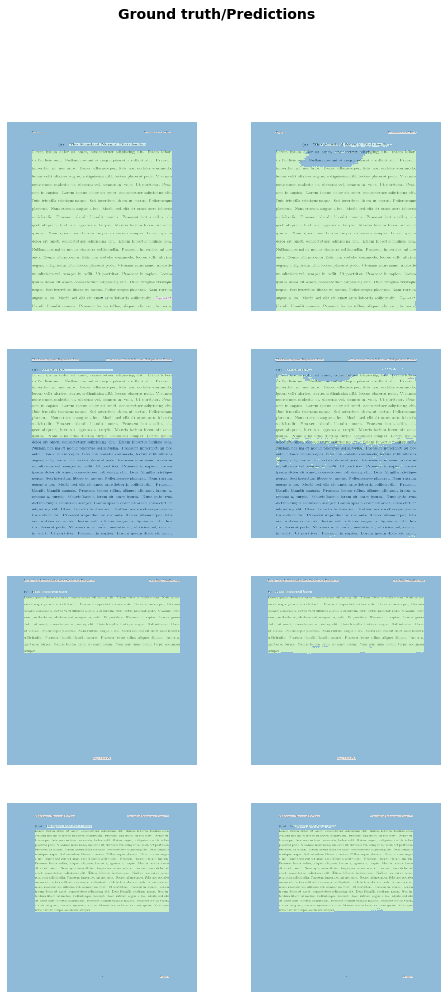

In [0]:
learn.show_results()

In [0]:
learn.export(r"/content/drive/My Drive/COLAB_MODEL1_RUN1/OUTPUT/Test_Model_run1.pkl")

# Import the model

In [13]:
imported_learn = load_learner(r"C:\Users\payman\Documents\Insight_Project\scrapworks\Test_Models\Model1", "Test_Model_run1.pkl", num_workers = 0)

In [14]:
img1 = open_image(r"C:\Users\payman\Documents\Insight_Project\scrapworks\Test_Models\Model1\Data/trainX_pngs/pdf_input_000_1-000001.png")

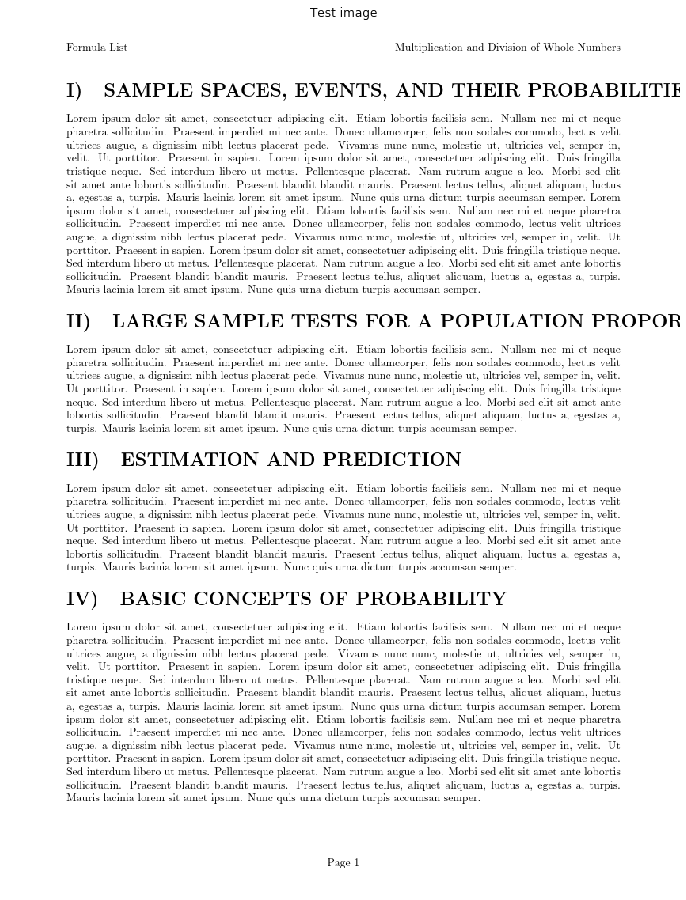

In [15]:
img1.show(figsize=(28, 16), title='Test image')

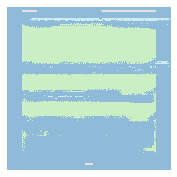

In [16]:
imported_learn.predict(img1)[0].show()

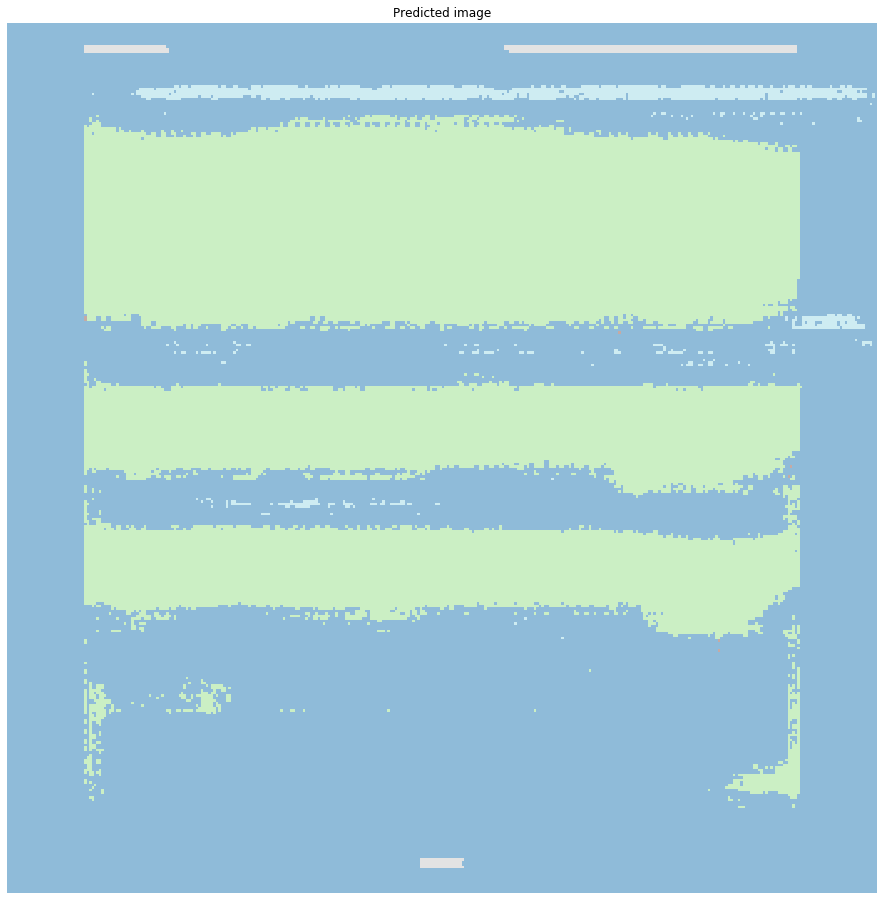

In [17]:
imported_learn.predict(img1)[0].show(figsize=(28, 16), title='Predicted image')

In [18]:
img2 = open_image(r"/content/drive/My Drive/COLAB_MODEL1_RUN1/Data/trainX_pngs/pdf_input_000_2-000001.png")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/COLAB_MODEL1_RUN1/Data/trainX_pngs/pdf_input_000_2-000001.png'

In [19]:
img2.show(figsize=(28, 16), title='Test image')

NameError: name 'img2' is not defined

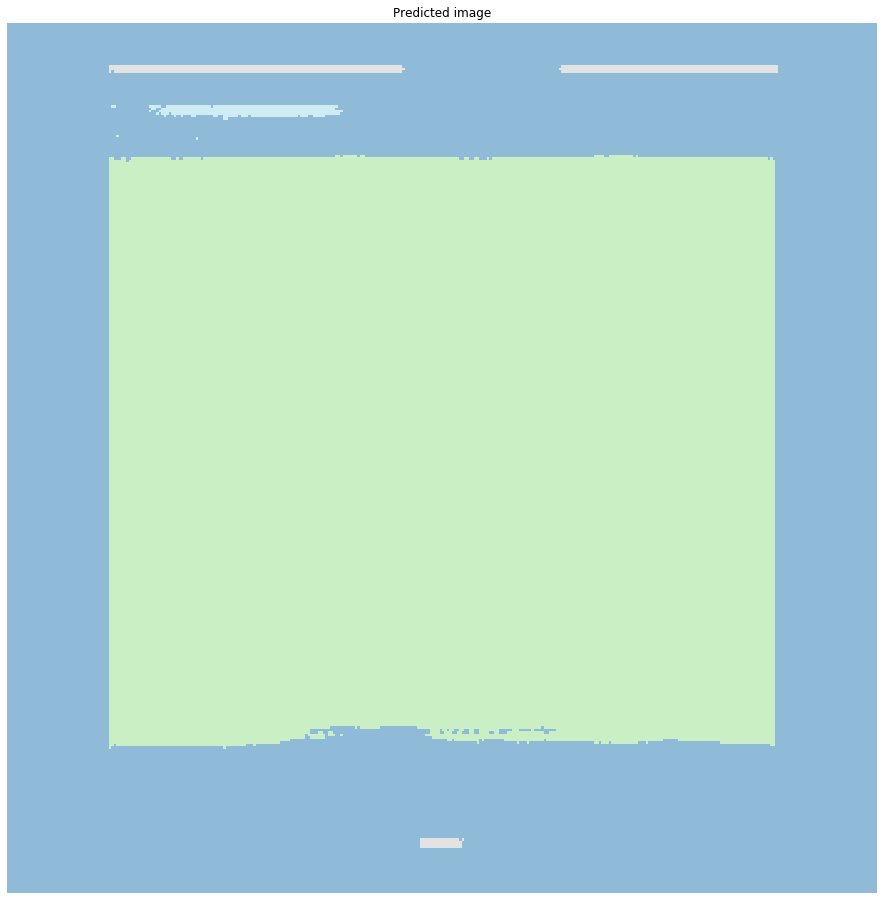

In [0]:
imported_learn.predict(img2)[0].show(figsize=(28, 16), title='Predicted image')

In [23]:
img3 = open_image(r"C:\Users\payman\Documents\Insight_Project\scrapworks\Test_Models\Model1\Data/trainX_pngs/pdf_input_000_4-000002.png")

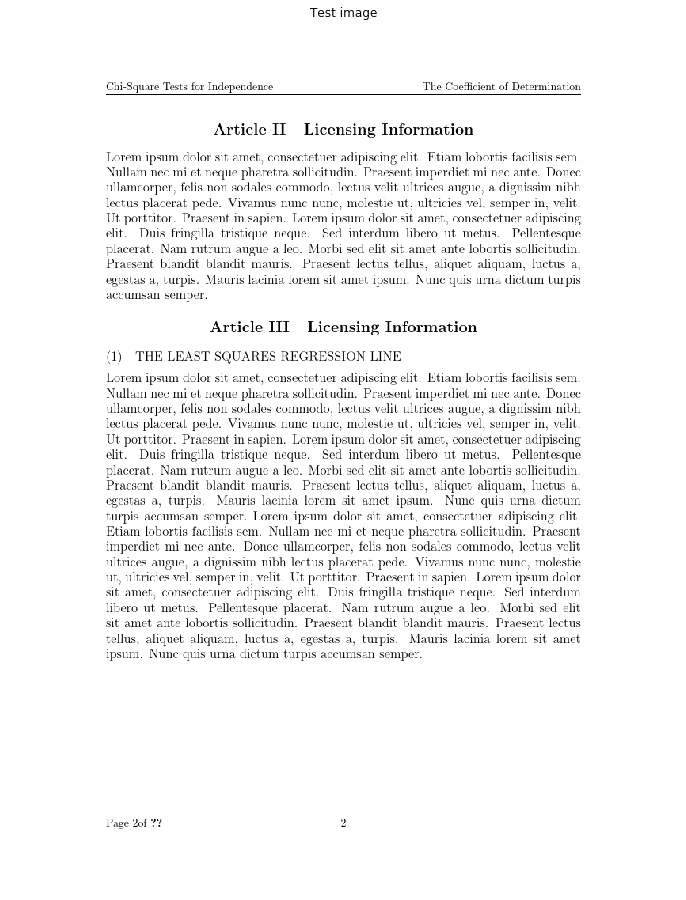

In [24]:
img3.show(figsize=(28, 16), title='Test image')

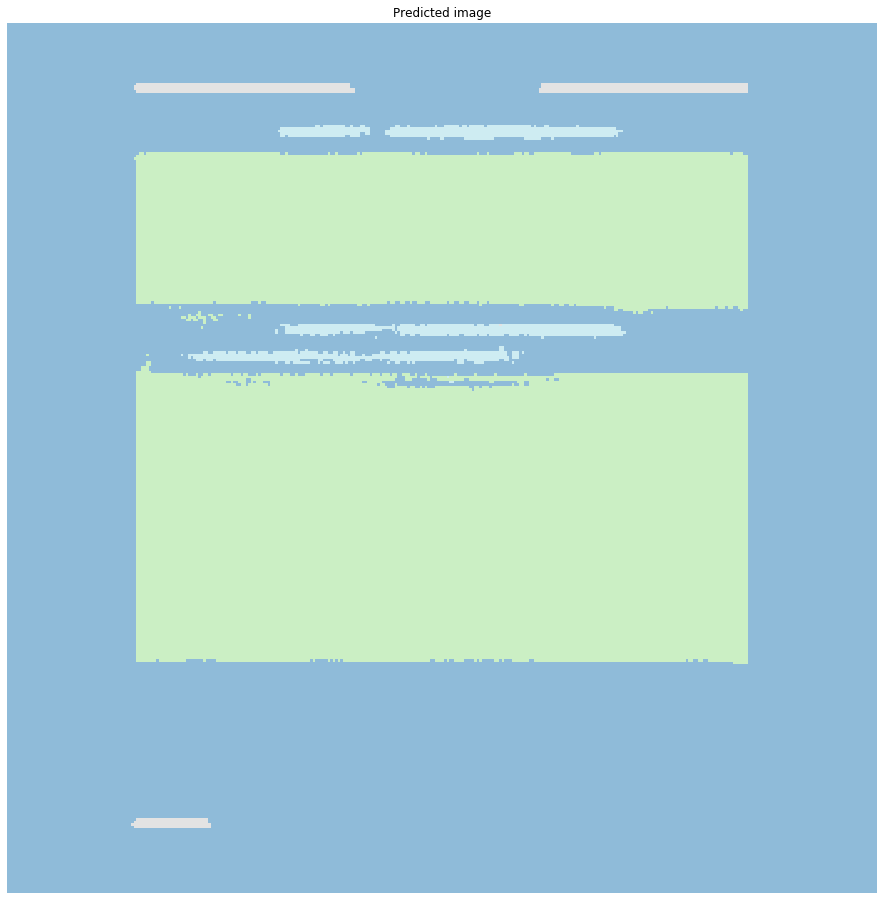

In [25]:
imported_learn.predict(img3)[0].show(figsize=(28, 16), title='Predicted image')

In [26]:
img4 = open_image(r"C:\Users\payman\Documents\Insight_Project\scrapworks\Test_Models\Model1\Data/trainX_pngs/pdf_input_000_4-000001.png")

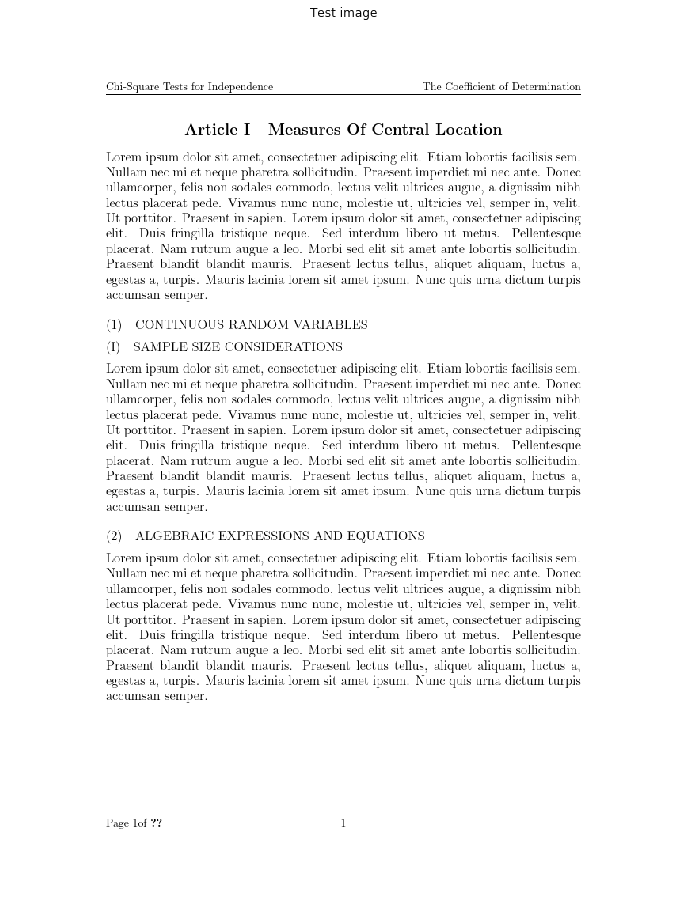

In [27]:
img4.show(figsize=(28, 16), title='Test image')

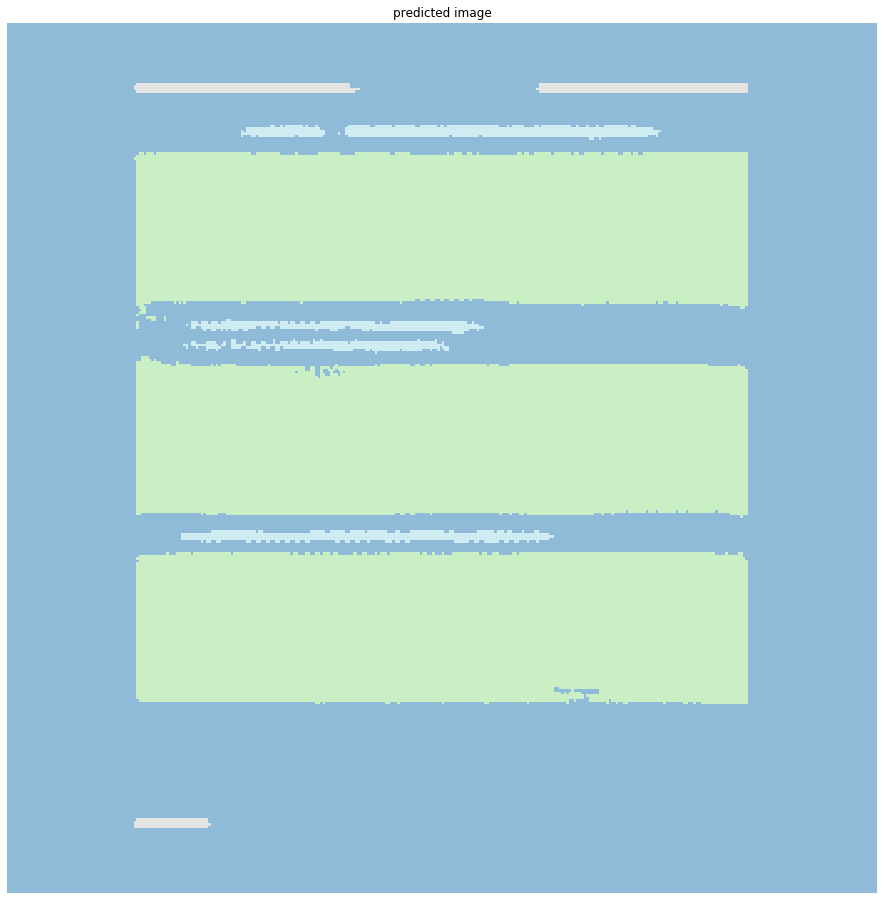

In [28]:
imported_learn.predict(img4)[0].show(figsize=(28, 16), title='predicted image')

_,axs = plt.subplots(1,2,figsize=(12,4))
for i,ax in enumerate(axs): img4.show(ax=ax, title=f'Copy {i+1}')